# Iteration 1<br/>*Create Baseline model*

Jupyter Notebook referenced from my website:
[Software Nirvana: Create Baseline Model](https://sdiehl28.netlify.com/projects/titanic/titanic01/)

### Goals
* Create simple baseline model
* Perform Exploratory Data Analysis
* Demonstrate details of Scikit Learn's:
  * KFold
  * StratifiedKFold (with shuffle=True and shuffle=False)
  * cross_val_score
* Measure baseline model's score and compare against null model

### Iterative Model Development
In order to demonstrate iterative model development, the titanic dataset from Kaggle will be used.

The purpose of these notebooks is **not** to teach how to predict on the titanic dataset!  There are many Kaggle kernels available for that.  The purpose of this series of notebooks is to illustrate iterative model development in general and to show how Scikit Learn methods work in particular.

The model will make a prediction for Survived / Not-Survived.  This is a supervised classification problem.

Several notebooks will be created after this one.  Each iteratively improving:
* the model's accuracy
* the workflow used to create the model

<a name="outline"></a>
### Outline
1. [Acquire and Read Data](#readdata)
2. [Identify Target Variable](#target)
3. [Tentative Assumptions For 1st Iteration](#assumptions)
4. [Exploratory Data Analysis](#eda)
5. [Model Building](#model)
8. [Model Evaluation: Cross Validation](#crossvalidation)
9. [Understanding StratifiedKFold and KFold](#kfold)
9. [Compare with Null Model](#modelcompare)
9. [Model Summary](#modelsummary)
0. [Notebook Summary](#summary)

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

<a name="readdata"></a>
### Acquire Data
[Back to Outline](#outline)

Download "train.csv" from: https://www.kaggle.com/c/titanic/data and place it in a data subdirectory.

This link also has the data dictionary (sometimes called the codebook).

### Read Data
Note that this example is for supervised learning, so we will only deal with labeled data.  The labeled dataset is named "train.csv".

In [2]:
all_data = pd.read_csv('../data/train.csv')
all_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<a name="target"></a>
### Target Variable: Survived
[Back to Outline](#outline)

Create two variables in preparation for creating a predictive model.  

X: A Pandas DataFrame that represents the features (aka attributes)  
y: A Pandas Series that represents the target (aka response)  

In [3]:
# X: drop target variable
# y: keep only the target
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']
print('X Shape: ', X.shape)
print('y Shape: ', y.shape)
print('X Type: ', type(X))
print('y Type: ', type(y))

X Shape:  (891, 11)
y Shape:  (891,)
X Type:  <class 'pandas.core.frame.DataFrame'>
y Type:  <class 'pandas.core.series.Series'>


In [4]:
# ndim, as in numpy, reports the number of dimensions (e.g. 1D, 2D)
print('X dimensions: ',X.ndim)
print('y dimensions: ',y.ndim)

X dimensions:  2
y dimensions:  1


<a name="assumptions"></a>
### First Iteration Assumptions
[Back to Outline](#outline)  

In order to quickly get something up and running, let's arbitrarily decide upon the following:
* use LogisticRegression
* drop ID field
* drop all non-numeric features
* drop any column having a null value
* use accuracy as the model evaluation metric

Note that most "estimators" in Scikit Learn, such as LogisticRegression, require all fields to be numeric and non-null.  This means all non-numeric fields must be converted to numeric fields or be dropped.  Likewise all fields having null values must have their null values replaced (imputated) or be dropped.

For the first iteration, we will drop all non-numeric fields and all fields with null values.  Later we will make good use of these fields.

In [5]:
X.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
# create a list of column names of type object
# the following works because X.dtypes is itself a Pandas Series
drop_fields = list(X.dtypes.index[X.dtypes.values == 'object'].values)
drop_fields

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [7]:
# IDs fields should never be features
drop_fields.append('PassengerId')
drop_fields

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'PassengerId']

In [8]:
# Remove all non-numeric fields and PassengerId (1st iteration only)
X = X.drop(drop_fields, axis=1)
X.dtypes

Pclass      int64
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

In [9]:
# which fields have null values
X.isnull().any()

Pclass    False
Age        True
SibSp     False
Parch     False
Fare      False
dtype: bool

In [10]:
# Remove all columns with null values (1st iteration only)
X.dropna(axis=1, inplace=True)
X.isnull().any()

Pclass    False
SibSp     False
Parch     False
Fare      False
dtype: bool

The data is now prepared for use with a Scikit Learn estimator. For classification problems, LogisticRegression is a good first estimator to experiment with.

<a name="eda"></a>
### Exploratory Data Analysis (of numeric variables)
[Back to Outline](#outline)

The codebook (aka data dictionary) from: https://www.kaggle.com/c/titanic/data is copied below.

```
Variable    Definition          Key
--------    ----------          -----
Survived    Survival	        0 = No, 1 = Yes
Pclass      Passenger class     1 = 1st, 2 = 2nd, 3 = 3rd
Sex         Sex	
Age         Age in years	
Sibsp       siblings+spouses aboard
Parch       parents+children aboard
Ticket      Ticket number	
Fare        Passenger fare	
Cabin       Cabin number	
Embarked    Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton
```

EDA itself should be performed on a subset of the data.  If a model developer is looking at both the train and test data, then the developer forms an idea in their mind as to how to incorporate the test data into the model. This is a subtle form of "data leakage".

**Although the goal of the first iteration is to get something up and running quickly, it is natural during the EDA process to come up with ideas for feature extraction that may be worthwhile to try later.  These ideas will be documented here.**

In [11]:
# randomly select half the data to explore
from numpy.random import choice
np.random.seed(100)
num_records = len(all_data)
idx = choice(range(num_records), size=num_records//2, replace=False)
eda_data = all_data.drop(drop_fields, axis=1)
eda_data = eda_data.iloc[idx]
print(f'Length of All Data: {len(all_data)}')
print(f'Length of EDA Data: {len(eda_data)}')

Length of All Data: 891
Length of EDA Data: 445


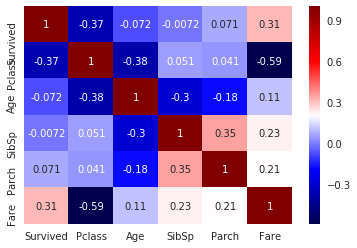

In [12]:
# heatmap of the linear correlation between each pair of numeric variables
sns.heatmap(eda_data.corr(), annot=True, cmap='seismic')

Note: passenger class is encoded as 1, 2, 3, so the lower the class, the better the class.

There are a number of interesting associations seen in the above plot, such as lower (better) passenger classes are associated with higher fares.  In the interest of brevity for this first iteration, associations not involving Survived, will not be discussed here.

### Examine Features with Respect to Survived

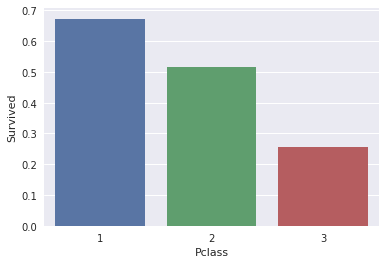

In [13]:
sns.barplot(x='Pclass',y='Survived',data=eda_data, ci=None)

In [14]:
# Seaborn's barplot, by default plots the equivalent of
eda_data.groupby(['Pclass'])['Survived'].mean()

Pclass
1    0.672566
2    0.516854
3    0.255144
Name: Survived, dtype: float64

Passenger class is not really a numeric variable.  It is an ordered categorical variable encoded as an integer.

The notion of distance is defined for numeric variables, but not for ordered categorical variables.  For example, the distance between 1st class and 2nd class is not the same as the distance between 2nd class and 3rd class; in fact distance is not defined.

Most estimators in SciKit Learn only accept non-null numbers.  Passenger class could be encoded as a "dummy variable" using one-hot encoding, or it could be left as is.

** As per the above barplot, the association between passenger class and survival rate is strong and the integer encoding captures the ordering of this association.  Therefore passenger class will remain encoded as an integer.**

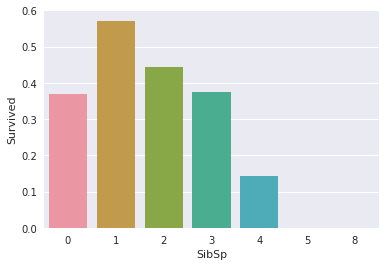

In [15]:
sns.barplot(x='SibSp',y='Survived',data=eda_data, ci=None)

Per the above, having no spouse or sibling on board reduced the survival rate.  It may be interesting to split this out as a new feature with two values, SibSp == 0 and SibSp > 0.

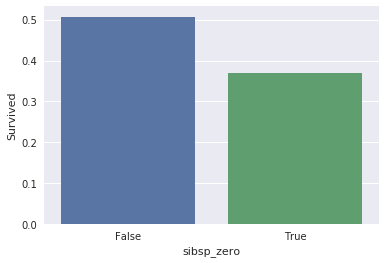

In [16]:
# proposed feature extraction: sibsp == 0
eda_data['sibsp_zero'] = (eda_data['SibSp'] == 0)
sns.barplot(x='sibsp_zero',y='Survived',data=eda_data, ci=None)

In [17]:
# plotted values
eda_data.groupby(['sibsp_zero'])['Survived'].mean()

sibsp_zero
False    0.507042
True     0.369637
Name: Survived, dtype: float64

**The survival rate when sibsp == 0 is lower than when it is above zero.  This could be a useful feature to add in a later iteration.**

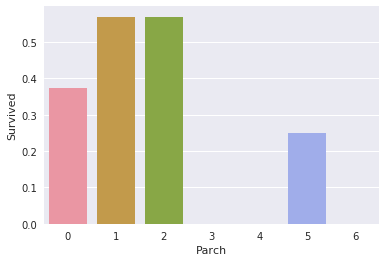

In [18]:
sns.barplot(x='Parch',y='Survived',data=eda_data, ci=None)

Per the above, having no parents or siblings on board reduced the survival rate.  It may be interesting to split this out as a new feature with two values, Parch == 0 and Parch > 0.

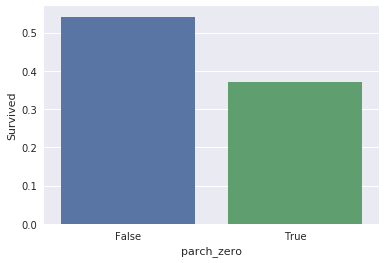

In [19]:
# proposed feature extraction: parch == 0
eda_data['parch_zero'] = (eda_data['Parch'] == 0)
sns.barplot(x='parch_zero',y='Survived',data=eda_data, ci=None)

In [20]:
# plotted values
eda_data.groupby(['parch_zero'])['Survived'].mean()

parch_zero
False    0.541284
True     0.372024
Name: Survived, dtype: float64

**The survival rate when parch == 0 is lower than when it is above zero.  This could be a useful feature to add in a later iteration.**

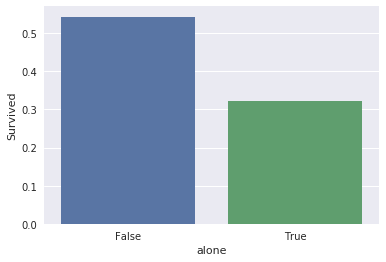

In [21]:
# traveling alone may have an even stronger association with survival rate
# proposed feature extraction: sibsp == 0 & parch == 0
eda_data['alone'] = (eda_data['parch_zero'] & eda_data['sibsp_zero'])
sns.barplot(x='alone',y='Survived',data=eda_data, ci=None)

In [22]:
# plotted values
eda_data.groupby(['alone'])['Survived'].mean()

alone
False    0.543478
True     0.321839
Name: Survived, dtype: float64

**Traveling alone reduces the survival rate.  This is likely a good feature to add to a future model.**

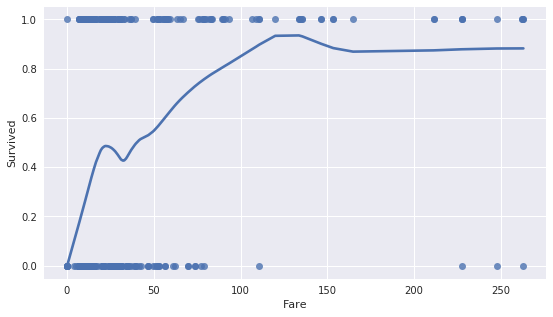

In [23]:
plt.figure(figsize=(9,5))
sns.regplot(x='Fare',y='Survived',data=eda_data, lowess=True)

"Lowess" is a non-parametric locally weighted smoother.  It is often useful for exploring nonlinear associations.  Here the lowess curve shows a mostly increasing rate of survival with respect to Fare.  The relationship is nonlinear with Fares above about \$80 having about an 80% chance of survival and fares above about \$45 have about a 50% chance of survival.  

It may be that the model can better incorporate the Fare variable if it is encoded as an integer representing an ordered categorical variable.  For example, above/below \$45 (2 values) or 0 to \$45, \$45 to \$80, \$80 and above (3 values).

For the first iteration, this exploration is just a note of what to try later.

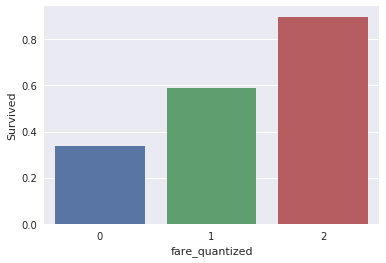

In [24]:
# proposed feature extraction
def quantize_fare(fare):
    if fare < 45:
        return 0
    elif fare < 80:
        return 1
    else:
        return 2
    
eda_data['fare_quantized'] = eda_data['Fare'].apply(quantize_fare)
sns.barplot(x='fare_quantized',y='Survived',data=eda_data, ci=None)

In [25]:
# plotted values
eda_data.groupby(['fare_quantized'])['Survived'].mean()

fare_quantized
0    0.338889
1    0.586957
2    0.897436
Name: Survived, dtype: float64

**It seems likely that this quantization of the fare variable will be helpful in a later iteration.**

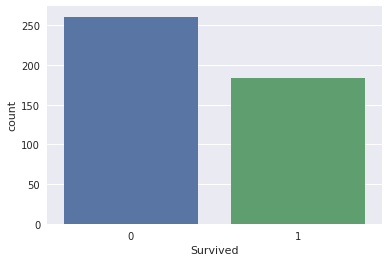

In [26]:
sns.countplot('Survived', data=eda_data)

In [27]:
eda_data['Survived'].value_counts()

0    261
1    184
Name: Survived, dtype: int64

** There are significantly less survivors than survivors.  When we create our train/test datasets for model evaluation, we should attempt to keep the same ratio of survived to non-survived, in each train/test dataset. **

In [28]:
# examine range (max-min), variance, mean, etc. of each feature
eda_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,fare_quantized
count,445.000000,445.000000,359.000000,445.000000,445.000000,445.000000,445.000000
mean,0.413483,2.292135,30.071727,0.492135,0.386517,32.267733,0.278652
std,0.493012,0.846325,14.474414,0.985506,0.832232,46.137149,0.614112
min,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,21.000000,0.000000,0.000000,7.925000,0.000000
50%,0.000000,3.000000,29.000000,0.000000,0.000000,14.500000,0.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.275000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,263.000000,2.000000


As per the above, Fare has a much wider range and higher standard deviation than any of the other variables.

By default, LogisticRegression uses regularization with penalty='l2'.  That is, the sum of the squares of the coefficients are constrained to add up to no more than C=1.0 (by default).

Whenever regularization is used, the variables should be represented on the same scale, otherwise the constraint on the coefficient could inappropriately favor a variable represented on a smaller scale.

A good normalization for LogisticRegression is Standardize().  **For a later iteration, Standardize() should be part of the preprocessing.**

<a name="model"></a>
### Model Building
[Back to Outline](#outline)

In [29]:
# Create instance of LogisticRegression estimator
from sklearn.linear_model import LogisticRegression
base_model = LogisticRegression()

<a name="crossvalidation"></a>
### Model Evaluation: Cross Validation
[Back to Outline](#outline)

Good resources for understanding cross validation and overfiting in Python:
* [Train/Test Split and Cross Validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
* [Learning Curves](https://www.dataquest.io/blog/learning-curves-machine-learning/)

Good resources for understanding cross validation and overfitting in general:
* chapter 5.1 of [ISL](http://www-bcf.usc.edu/~gareth/ISL/)
* The first 3 videos for Chapter 5 [ISL Videos](http://www.dataschool.io/15-hours-of-expert-machine-learning-videos/)

In [30]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score

# Recommended Values are 5 or 10
k_folds = 10

# For repeatability
random_seed=5

# Setup for Stratified K fold Cross Validation
# We want stratified because the number of non-survived is 
# much greater than the number of survived
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

# compute cross validated scores for each of the K=10 folds
scores = cross_val_score(base_model, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

# save scores for comparison with another iteration
np.save("../data/iter01.data", scores)

# print results
print('Scores: \n', np.round(scores, 3))
print(f'Cross Validated Accuracy: {scores.mean():.3f}')

Scores: 
 [0.667 0.722 0.674 0.685 0.708 0.674 0.663 0.652 0.719 0.705]
Cross Validated Accuracy: 0.687


<a name="kfold"></a>
### StratifiedKFold, KFold, and cross_val_score
[Back to Outline](#outline)  

The above code for cross validation did not take many lines of code, but what exactly happened?

What does StratifiedKFold do that's different from KFold?  
What does shuffle=True do that's different than shuffle=False?  
What is cross_val_score doing?

Below, these questions will be answered.

In [31]:
k_folds = 10
random_seed = 5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=False, 
                                  random_state=random_seed)

# get train and test sets for crossvaldiation
train_test_sets = [(train_idx, test_idx) for 
                   train_idx, test_idx in crossvalidation.split(X,y)]

# in Python, looking at data types helps understanding
print(f'List Comprehension Type:    {type(train_test_sets)}')
print(f'List Len:                   {len(train_test_sets)}')
print(f'1st Element Type:           {type(train_test_sets[0])}')
print(f'1st Element Len:            {len(train_test_sets[0])}')
print(f'1st Element 1st Tuple Type: {type(train_test_sets[0][0])}')
print(f'1st Element 1st Tuple Len:  {len(train_test_sets[0][0])}')
print(f'1st Element 2nd Tuple Type: {type(train_test_sets[0][1])}')
print(f'1st Element 2nd Tuple Len:  {len(train_test_sets[0][1])}')
print(f'Data Length:                {len(X)}')

List Comprehension Type:    <class 'list'>
List Len:                   10
1st Element Type:           <class 'tuple'>
1st Element Len:            2
1st Element 1st Tuple Type: <class 'numpy.ndarray'>
1st Element 1st Tuple Len:  801
1st Element 2nd Tuple Type: <class 'numpy.ndarray'>
1st Element 2nd Tuple Len:  90
Data Length:                891


Describing the above in words:
* The train_test_sets list is of length 10 (10 CV folds).
* Each element in the list is a tuple which consists of 2 numpy arrays.
* The first array in the tuple are the indexes used to created the training data.  It is of length 801.
* The second array in the tuple are the indexes used to created the test data.  It is of length 90.
* The total length of all data is 891 records.

In [32]:
# Experiement: KFold with shuffle=False
crossvalidation = KFold(n_splits=k_folds, shuffle=False, 
                        random_state=random_seed)

train_test_sets = [(train_idx, test_idx) for 
                   train_idx, test_idx in crossvalidation.split(X,y)]

# Check: for contiguous blocks of records in the test set
# if the records are contiguous, each index differs by 1
for i in range(10):
    print((np.diff(train_test_sets[i][1]) == 1).all(), end=' ')

True True True True True True True True True True 

In [33]:
# print one fold of test set indexes
train_test_sets[0][1]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89])

So KFold with shuffle=False means we are using test sets that represent blocks of contiguous records.

A contiguous block of records for the test set means that the training set is as contiguous as possible.

In [34]:
# Experiement: KFold with shuffle=True
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

train_test_sets = [(train_idx, test_idx) for 
                   train_idx, test_idx in crossvalidation.split(X,y)]

# Check: for contiguous blocks of records in the test set
# if the records are contiguous, each index differs by 1
for i in range(10):
    print((np.diff(train_test_sets[i][1]) == 1).all(), end=' ')

False False False False False False False False False False 

In [35]:
# print one fold of test set indexes
train_test_sets[0][1]

array([ 11,  12,  23,  28,  59,  60, 121, 126, 133, 138, 148, 176, 199,
       207, 212, 230, 244, 247, 258, 261, 267, 275, 286, 293, 295, 312,
       316, 322, 329, 349, 352, 354, 361, 363, 379, 383, 386, 409, 417,
       419, 424, 433, 434, 438, 440, 443, 445, 451, 452, 470, 475, 481,
       509, 544, 545, 563, 568, 576, 590, 591, 610, 636, 644, 673, 679,
       682, 683, 692, 695, 724, 727, 733, 735, 737, 747, 757, 759, 765,
       769, 792, 807, 827, 828, 840, 843, 845, 857, 872, 877, 886])

So shuffle=True caused non-consecutive indexes to be used for determining the test datasets.

This implies that non-consecutive indexes are also used for the train datasets.

In other words, we are no longer using blocks of records from the original dataset for our train and test sets.

In [36]:
# Experiement: KFold with shuffle=True
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

train_test_sets = [(train_idx, test_idx) for 
                   train_idx, test_idx in crossvalidation.split(X,y)]

# Check: for frequency of class labels
# Note: y only has values of 0 or 1, so y.mean() is the frequency of 1 values
print('y: ', np.round(y.mean(), 2))

# print frequency of survival in the 10 train and 10 test sets
for i in range(10):
    for j in range(2):
        print(np.round(y[train_test_sets[i][j]].mean(), 2), end=' ')

y:  0.38
0.38 0.4 0.39 0.36 0.39 0.37 0.39 0.33 0.38 0.45 0.38 0.39 0.38 0.39 0.38 0.4 0.39 0.36 0.38 0.38 

So KFold did *not* keep the percentage of survivors the same in each dataset.  Values as low as 33% and as high as 45% are seen.

In [37]:
# Experiement: StratifiedKFold with shuffle=True
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

train_test_sets = [(train_idx, test_idx) for 
                   train_idx, test_idx in crossvalidation.split(X,y)]

# Check: for frequency of class labels
# Note: y only has values of 0 or 1, so y.mean() is the frequency of 1 values
print('y: ', np.round(y.mean(), 2))

# print frequency of survival in the 10 train and 10 test sets
for i in range(10):
    for j in range(2):
        print(np.round(y[train_test_sets[i][j]].mean(), 2), end=' ')

y:  0.38
0.38 0.39 0.38 0.39 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.39 

So StratifiedKFold caused about the same percentage of survivors to occur in each training and test dataset.

#### Summary of StratifedKFold and KFold
For classification, you want each train/test subset to have (about) the same frequency of class values as is represented in the entire target array, so you normally **choose StratifiedKFold instead of KFold**.

The original dataset may have an inherent ordering.  This ordering could bias your train/test splits.  To avoid this, you normally  ** choose shuffle=True**.

** NOTE **  
shuffle=True does **not** cause the test sets to overlap.  It is not like SuffleSplit.

In [38]:
# Show: test sets do not overlap when suffle=True
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

train_test_sets = [(train_idx, test_idx) for 
                   train_idx, test_idx in crossvalidation.split(X,y)]

# In this example, there are 10 disjoint test sets.
# This is equivalent to saying that each check for intersection between
# each pair of test sets, has a length of 0

# Intersection is commutative, so we only need to check half of the possible
# pairs of test sets and we don't check a test set with itself

for i in range(10):
    for j in range(i+1, 10):
        print(len(np.intersect1d(train_test_sets[i][1],train_test_sets[j][1])), end=' ')

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

We see that the test sets are disjoint. shuffle=True in this context does not cause test set overlap.

In [39]:
# Show: train set is disjoint from its respective test set
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

train_test_sets = [(train_idx, test_idx) for 
                   train_idx, test_idx in crossvalidation.split(X,y)]

for i in range(10):
        print(len(np.intersect1d(train_test_sets[i][0],train_test_sets[i][1])), end=' ')

0 0 0 0 0 0 0 0 0 0 

There are no index values in the train dataset that are in the corresponding test dataset.

#### Compute Cross Validated Score without using cross_val_score

In [40]:
# Alternative computation of cross validated scores

# From Above
k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

# Use crossvalidation iterator explicitly
my_scores = np.zeros(k_folds)
i = 0
lr_model = LogisticRegression()
for train_idx, test_idx in crossvalidation.split(X,y):
    
    # train subset
    X_train = X.iloc[train_idx, :]
    y_train = y[train_idx]
    
    # test subset
    X_test = X.iloc[test_idx, :]
    y_test = y[test_idx]
    
    # fit model on train
    lr_model.fit(X_train, y_train)
    
    # predict using fitted model on test
    predictions = lr_model.predict(X_test)
    
    # evaluate accuracy
    my_scores[i] = accuracy_score(y_test, predictions)
    i += 1

# print results
print('Scores: \n', np.round(scores, 3))
print(f'Cross Validated Accuracy: {scores.mean():.3f}')

# compare with scores computed by cross_val_score() above
print('Scores match: ',(scores == my_scores).all())

Scores: 
 [0.667 0.722 0.674 0.685 0.708 0.674 0.663 0.652 0.719 0.705]
Cross Validated Accuracy: 0.687
Scores match:  True


The scores match.  The computations are the same.  The above for-loop does exactly the same thing as the following single line:
```python
scores = cross_val_score(base_model, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)
```

<a name="modelcompare"></a>
### Compare with Null Model
[Back to Outline](#outline)

For a classifier, predicting the predominant class is the simplest possible model.  This is sometimes referred to as the "null model".

In [41]:
from sklearn.dummy import DummyClassifier

k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

null_model = DummyClassifier(strategy='most_frequent',random_state=0)

null_model_scores = cross_val_score(null_model, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=-1)

print('Scores: \n', np.round(null_model_scores, 3))
print(f'Cross Validated Accuracy: {null_model_scores.mean():.3f}')

Scores: 
 [0.611 0.611 0.618 0.618 0.618 0.618 0.618 0.618 0.618 0.614]
Cross Validated Accuracy: 0.616


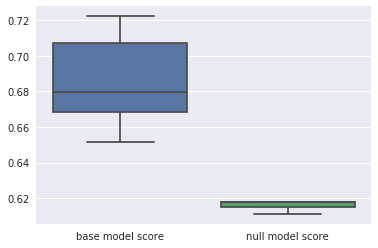

In [42]:
# compare the scores graphically
df = pd.DataFrame(data=list(zip(scores, null_model_scores)),
                  columns=['base model score','null model score'])
sns.boxplot(data=df)

We see that the base model cross validated scores are well above the null model cross validated scores.

<a name="modelsummary"></a>
### Model Summary
[Back to Outline](#outline)

Model building steps only.

In [43]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')

# create target and feature variables
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

# remove all fields of type object
drop_fields = list(X.dtypes.index[X.dtypes.values == 'object'].values)

# also remove the ID field
drop_fields.append('PassengerId')
X = X.drop(drop_fields, axis=1)

# remove the remaining column having null values
X = X.dropna(axis=1)

# create model instance
base_model = LogisticRegression()

# Recommended Values are 5 or 10
k_folds = 10

# For repeatability
random_seed=5

# Create the K Cross Validation Train/Test Splits
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

# compute cross validated scores for each of the K=5 folds
scores = cross_val_score(base_model, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=-1)

# print results
print('Scores: \n', np.round(scores, 3))
print(f'Cross Validated Accuracy: {scores.mean():.3f}')

Scores: 
 [0.667 0.722 0.674 0.685 0.708 0.674 0.663 0.652 0.719 0.705]
Cross Validated Accuracy: 0.687


<a name="summary"></a>
### Notebook Summary
[Back to Outline](#outline)

In this first iteration we:
* performed EDA
* discussed how StratifedKFold, KFold and cross_val_score work
* created a simple model to use as our baseline
* established a baseline accuracy of 68.7%
* created the simplest possible "null model" for comparison
* showed that our baseline model accuracy (68.7%) is better than the null model (61.6%)